# 0. IMPORTS

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb
import researchpy as rp
import inflection
import warnings

import matplotlib.pyplot as plt
import scikitplot as skplot

from sklearn.preprocessing   import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.metrics         import top_k_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from boruta                  import BorutaPy
from IPython.display         import Image

## 0.1 Parameters and Other Settings

In [2]:
# ignore warnings
warnings.filterwarnings('ignore')

## 0.2 Load Data

In [3]:
# load data with pandas
df_raw = pd.read_csv('C:/Users/andre/repos/purchase-propensity/data/train.csv', low_memory=False)

In [4]:
# check first 5 rows
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1. FUNCTIONS

In [5]:
def cramers_v(data, x, y):
    '''
    Function that calculates the correlation between 2 categorical features

    Parameters:
        data: the dataset with the project data
        x: Feature 1
        y: Feature 2
        
    Returns: 
        Cramer's V coefficient
    '''
    
    return rp.crosstab(data[x], data[y], prop='col', test='chi-square')[1]['results'][2]

In [74]:
def precision_at_k(y_true, y_pred, k=2000):
    
    ordered_values = [i for _, i in sorted(zip(y_pred[:, 1], range(1, len(y_true+1))), reverse=True)]
    
    return '{:.4f}'.format(np.sum(y_val.iloc[ordered_values[:k]]) / k)

In [75]:
def recall_at_k(y_true, y_pred, k=2000):
    
    ordered_values = [i for _, i in sorted(zip(y_pred[:, 1], range(1, len(y_true+1))), reverse=True)]
    
    return '{:.4f}'.format(np.sum(y_val.iloc[ordered_values[:k]]) / np.sum(y_val))

# 2. DATA CLEANING AND DESCRIPTION

In [9]:
df2 = df_raw.copy()

## 2.1 Rename Columns

In [10]:
# get all columns name
df2_cols = df2.columns.to_list()

# function to transform all names in snake case
transform_snake_case = lambda x: inflection.underscore(x)

# apply function and rename columns
df2.columns = (list(map(transform_snake_case,  df2_cols)))

## 2.2 Data Dimensions

In [11]:
print(f'The dataset have {df2.shape[0]} rows and {df2.shape[1]} columns')

The dataset have 381109 rows and 12 columns


## 2.3 Data Types

In [12]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 2.4 Check NA's

In [13]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 2.5 Descriptive Statistics

### 2.5.1 Numerical Features

In [14]:
# filtering numerical features
num_features = df2.select_dtypes(include=['float64', 'int64'])

In [15]:
# count, mean, std, min, quartiles, max
metrics = num_features.describe().T

# range
metrics['range'] = metrics['max'] - metrics['min']

# skew
metrics['skew'] = num_features.skew()

# kurtosis
metrics['kurtosis'] = num_features.kurtosis()

# organize dataframe
metrics = metrics[['count', 'min', 'max', 'range', 'mean', 'std', '25%', '50%', '75%', 'skew', 'kurtosis']]

# rename columns
metrics.rename(columns={'50%': 'median'}, inplace=True)

In [16]:
metrics

,count,min,max,range,mean,std,25%,median,75%,skew,kurtosis
id,381109.0,1.0,381109.0,381108.0,190555.000000,110016.836208,95278.0,190555.0,285832.0,9.443274e-16,-1.200000
age,381109.0,20.0,85.0,65.0,38.822584,15.511611,25.0,36.0,49.0,6.725390e-01,-0.565655
driving_license,381109.0,0.0,1.0,1.0,0.997869,0.046110,1.0,1.0,1.0,-2.159518e+01,464.354302
region_code,381109.0,0.0,52.0,52.0,26.388807,13.229888,15.0,28.0,35.0,-1.152664e-01,-0.867857
previously_insured,381109.0,0.0,1.0,1.0,0.458210,0.498251,0.0,0.0,1.0,1.677471e-01,-1.971871
annual_premium,381109.0,2630.0,540165.0,537535.0,30564.389581,17213.155057,24405.0,31669.0,39400.0,1.766087e+00,34.004569
policy_sales_channel,381109.0,1.0,163.0,162.0,112.034295,54.203995,29.0,133.0,152.0,-9.000081e-01,-0.970810
vintage,381109.0,10.0,299.0,289.0,154.347397,83.671304,82.0,154.0,227.0,3.029517e-03,-1.200688
response,381109.0,0.0,1.0,1.0,0.122563,0.327936,0.0,0.0,0.0,2.301906e+00,3.298788


### 2.5.2 Categorical Features

In [17]:
cat_features = df2.select_dtypes(exclude=['float64', 'int64'])

# number of categories per feature
cat_features.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

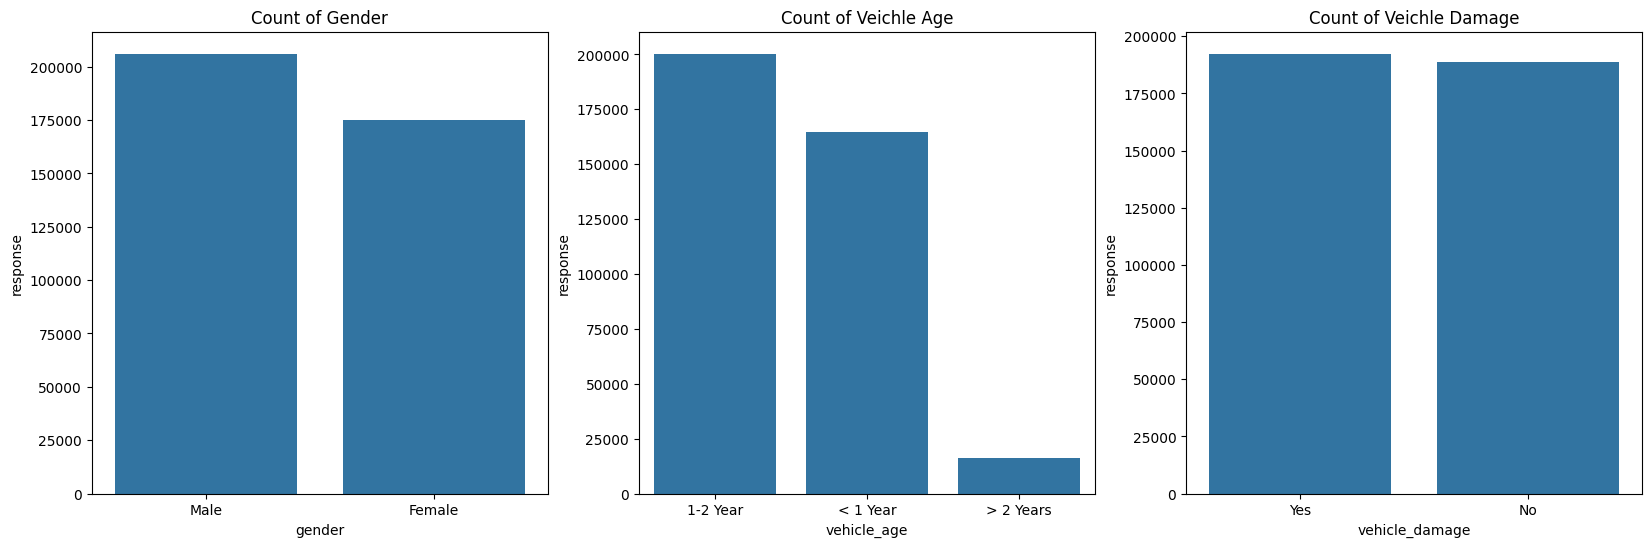

In [18]:
# plot categorical features 

fig = plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
aux1 = pd.DataFrame(cat_features['gender'].value_counts()).reset_index()
ax1 = sns.barplot(x='gender', y='count', data=aux1)
ax1.set_title('Count of Gender')
ax1.set_ylabel('response')

plt.subplot(1, 3, 2)
aux2 = pd.DataFrame(cat_features['vehicle_age'].value_counts()).reset_index()
ax2 = sns.barplot(x='vehicle_age', y='count', data=aux2)
ax2.set_title('Count of Veichle Age')
ax2.set_ylabel('response')

plt.subplot(1, 3, 3)
aux3 = pd.DataFrame(cat_features['vehicle_damage'].value_counts()).reset_index()
ax3 = sns.barplot(x='vehicle_damage', y='count', data=aux3)
ax3.set_title('Count of Veichle Damage')
ax3.set_ylabel('response')

plt.show()

# 3. HYPOTHESIS MINDMAP

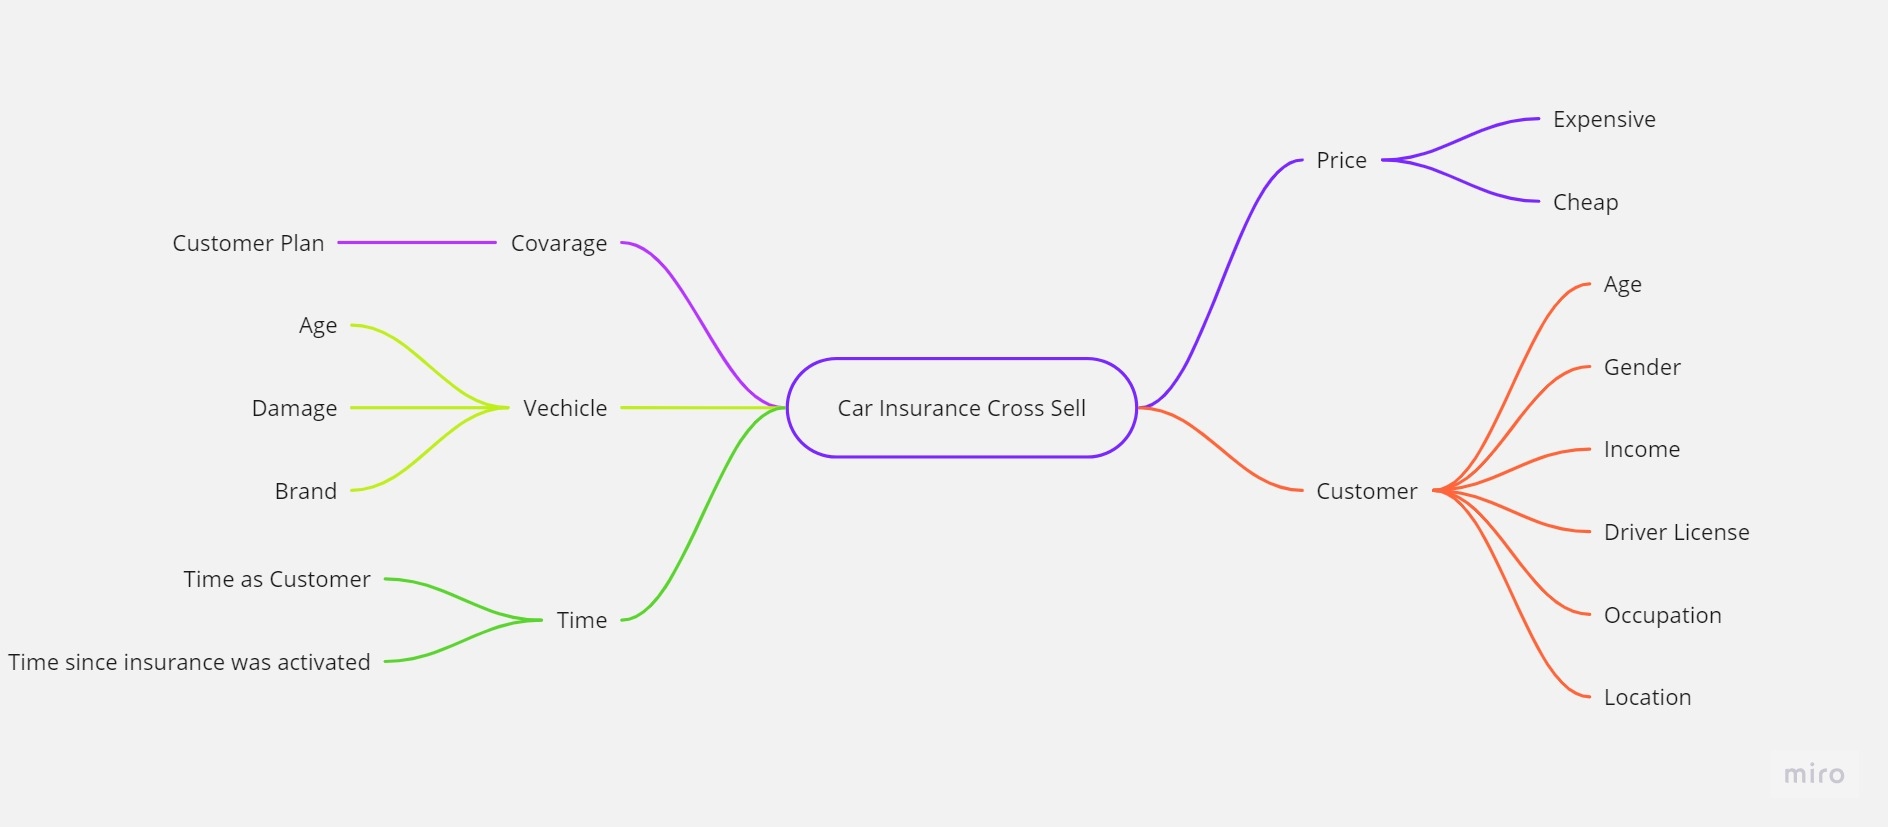

In [19]:
Image("C:/Users/andre/repos/purchase-propensity/data/hypothesis_mindmap.jpg")

## 3.1 Hypothesis List

### 3.1.1 Covarage

1. Customers with more health insurance coverage tend to respond more positively

### 3.1.2 Vehicle

1. Customers with older cars tend to respond positively
2. Customers who are involved in more accidents tend to respond positively
3. Customers with more frequent mechanical problems tend to respond positively
4. Depending on the car brand, customers may respond more positively

### 3.1.3 Time

1. The length of time the client has had health insurance does not influence their response
2. The time it took the client to activate the insurance does not influence their answer
3. Customers who have taken out insurance more often tend to respond more positively

### 3.1.4 Price

1. Customers who pay for cheaper health insurance plans tend to respond more positively
2. Most customers pay for more expensive plans

### 3.1.5 Customer

1. Male customers tend to respond more positively
2. The rate of customers who respond positively over the age of 60 is 2x that of those under 60
3. Customers with a driver's license respond more positively
4. Customers who earn higher salaries respond more positively
5. Customers earning higher salaries tend to choose cheaper plans

## 3.2 Prioritized List

1. Customers with older cars tend to respond positively
2. Customers with more frequent mechanical/accident, problems tend to respond positively
3. The length of time the client has had health insurance does not influence their response
4. Customers who pay for cheaper health insurance plans tend to respond more positively
5. Most customers pay for more expensive plans
6. Male customers tend to respond more positively
7. The rate of customers who respond positively over the age of 60 is 2x that of those under 60
8. Male customers have more vehicle damages
9. There are richest regions than in comparasion to others

# 4. FEATURE ENGINEERING

In [20]:
df4 = df2.copy()

In [21]:
# veichle age
df4['vehicle_age'] = df4['vehicle_age'].apply(lambda x: 'more_than_2_years' if x == '> 2 Years' else 
                                                        'between_1_2_years' if x == '1-2 Year' else 
                                                        'less_than_1_year')

# veichle damage
df4['vehicle_damage'] = df4['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# gender 
df4['gender'] = df4['gender'].apply(lambda x: inflection.underscore(x))

# age_bucket
df4['age_bucket'] = df4['age'].apply(lambda x: 'young_adult'   if x >= 20 and x < 27 else
                                               'adult'         if x >= 27 and x < 41 else
                                               'senior_adult'  if x >= 41 and x < 55 else
                                               'young_elderly' if x >= 55 and x < 61 else
                                               'elderly'       if x >= 61 and x < 76 else
                                               'senior_elderly')

In [22]:
df4.sample(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,age_bucket
197438,197439,male,49,1,28.0,0,between_1_2_years,1,50379.0,26.0,17,0,senior_adult
166643,166644,male,23,1,28.0,1,less_than_1_year,0,49714.0,152.0,137,0,young_adult
144573,144574,female,21,1,28.0,0,between_1_2_years,1,2630.0,157.0,230,0,young_adult
357767,357768,female,25,1,50.0,1,less_than_1_year,0,43177.0,152.0,215,0,young_adult
39096,39097,male,49,1,15.0,0,between_1_2_years,1,33956.0,14.0,121,1,senior_adult


## 4.1 Data Filtering

### 4.1.1 Rows

In [23]:
## no row filtering

### 4.2.1 Columns

In [24]:
## no column filtering

# 5. EXPLORATORY DATA ANALYSIS

In [25]:
df5 = df4.copy()

## 5.1 Univariate Analysis

In [26]:
# Research response rate
df5['response'].mean()

0.12256336113815208

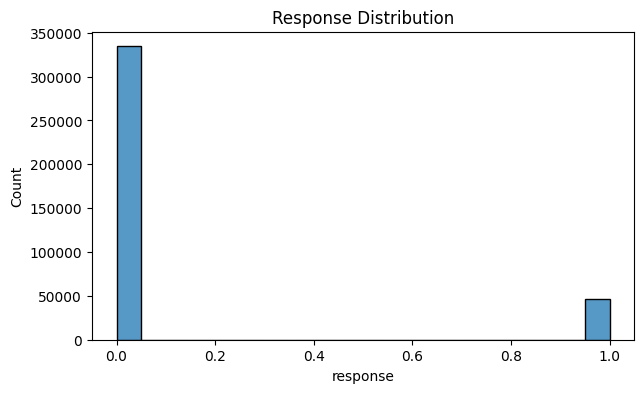

In [27]:
fig, ax = plt.subplots(figsize=(7, 4))

sns.histplot(df5['response'], ax=ax)
ax.set_title('Response Distribution')

#df5['response'].plot(kind='hist')
plt.show()

In [28]:
# Response frequency
df5['response'].value_counts(normalize=True)

response
0    0.877437
1    0.122563
Name: proportion, dtype: float64

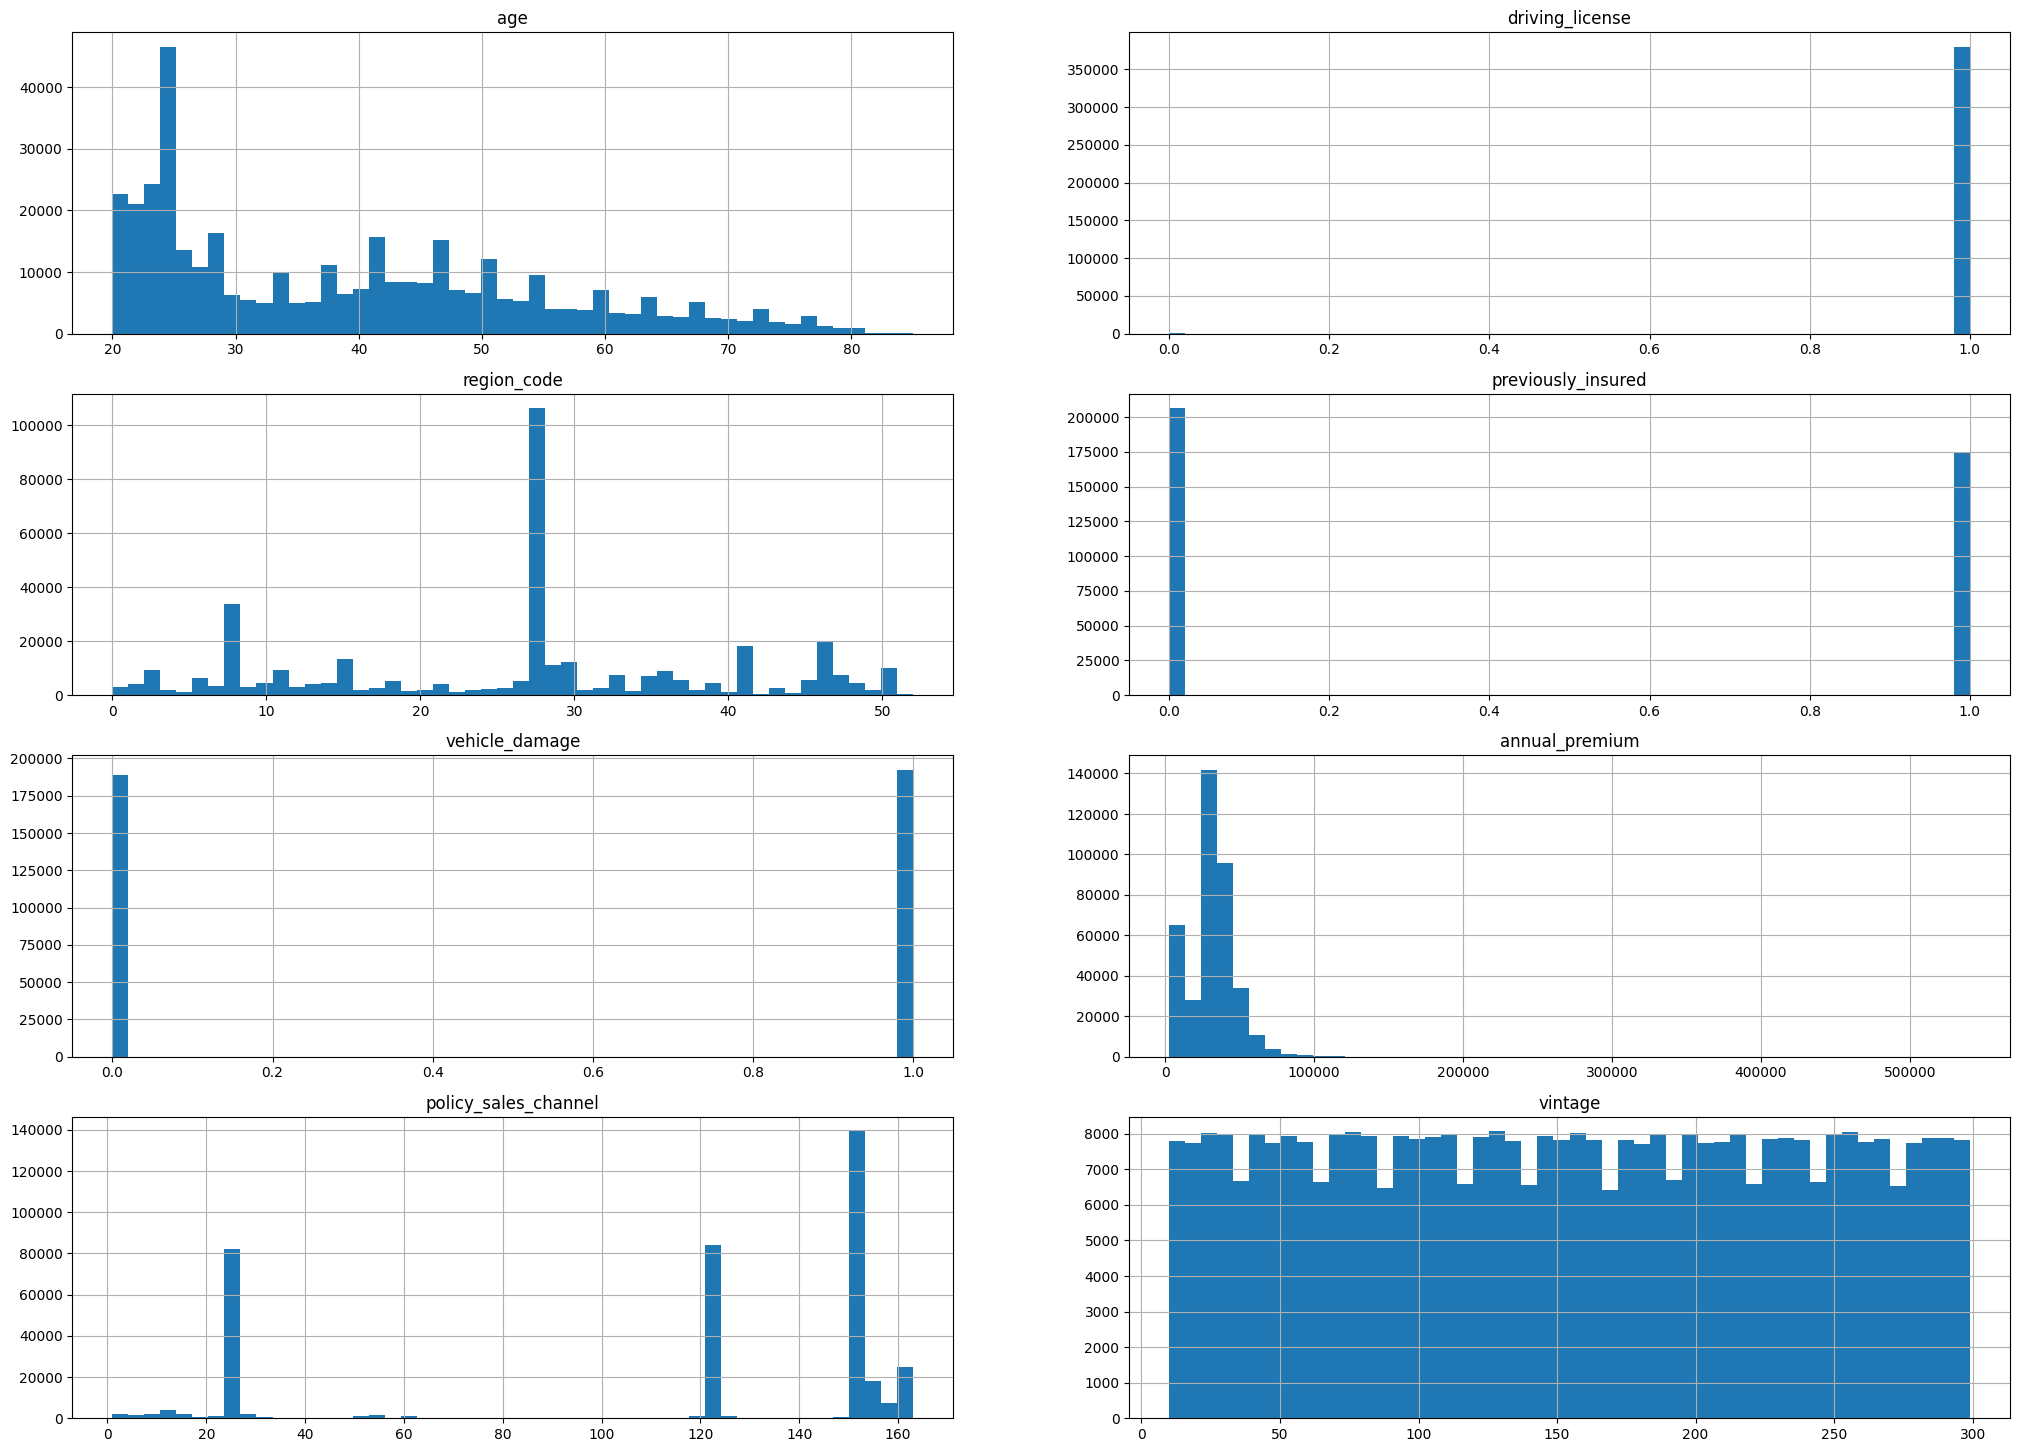

In [29]:
# plot numerical attributes distribution
plt.figure(figsize=(25, 18))

num_features = df5.select_dtypes(include=['int64', 'float64']).drop(columns=['id', 'response'], axis=1)

cols = num_features.columns.to_list()

for i in range(0, len(cols)):
    ax = plt.subplot(4, 2, i+1)
    ax.set_title(cols[i])

    num_features[cols[i]].hist(bins=50)

plt.show()

## 5.2 Bivariate Analysis

### 5.2.1. Customers with older cars tend to respond positively  

**True**: Customers with older cars tend to response more positively with the interest in acquiring a insurance

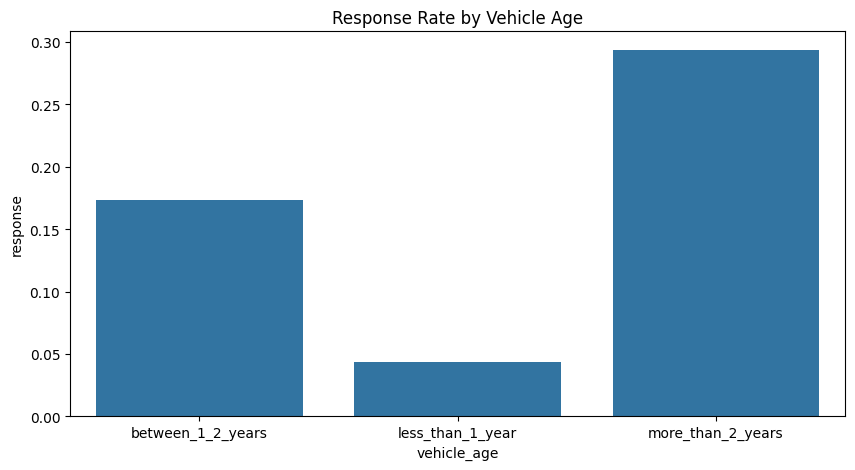

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
aux1 = df5[['vehicle_age', 'response']].groupby('vehicle_age').mean().reset_index()

sns.barplot(data=aux1, x='vehicle_age', y='response', ax=ax)
ax.set_title('Response Rate by Vehicle Age')

plt.show()

### 5.2.2 Customers with more frequent mechanical/accident, problems tend to respond positively  

**True**: Customers who have gad some kind of damage in their vehicles are more interested in acquiring an insurance.

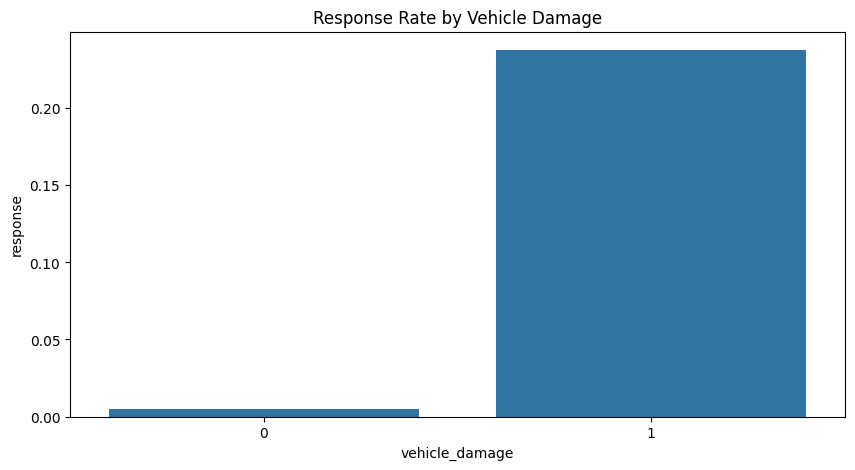

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
aux2 = df5[['vehicle_damage', 'response']].groupby('vehicle_damage').mean().reset_index()

sns.barplot(data=aux2, x='vehicle_damage', y='response', ax=ax)
ax.set_title('Response Rate by Vehicle Damage')

plt.show()

### 5.2.3 The length of time the client has had health insurance does not influence their response  

**True**: The chart doesn't seem to point to any tendency (as time passes, the response rate don't point to any direction). So, we can say that is true, time doesn't impact in the customer intention of acquiring an insurance.

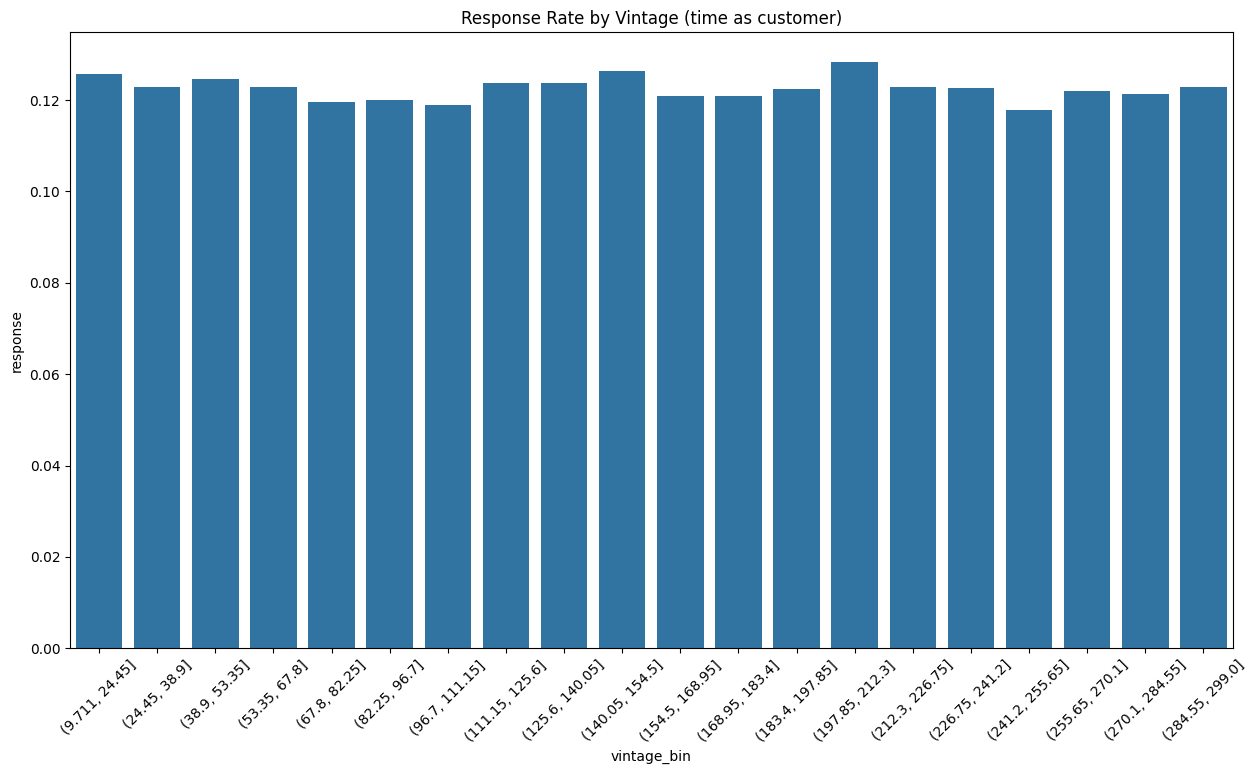

In [32]:
fig, ax = plt.subplots(figsize=(15, 8))

aux3 = df5[['vintage', 'response']]
aux3['vintage_bin'] = pd.cut(aux3['vintage'], bins=20)
aux3 = aux3[['vintage_bin', 'response']].groupby('vintage_bin').mean().reset_index()

sns.barplot(data=aux3, x='vintage_bin', y='response', ax=ax)
ax.set_title('Response Rate by Vintage (time as customer)')
plt.xticks(rotation=45)

plt.show()

### 5.3.4 Customers who pay for cheaper health insurance plans tend to respond more positively  

**False**: The feature behavior indicates that people with more expensive plans, tend to responde more positively.

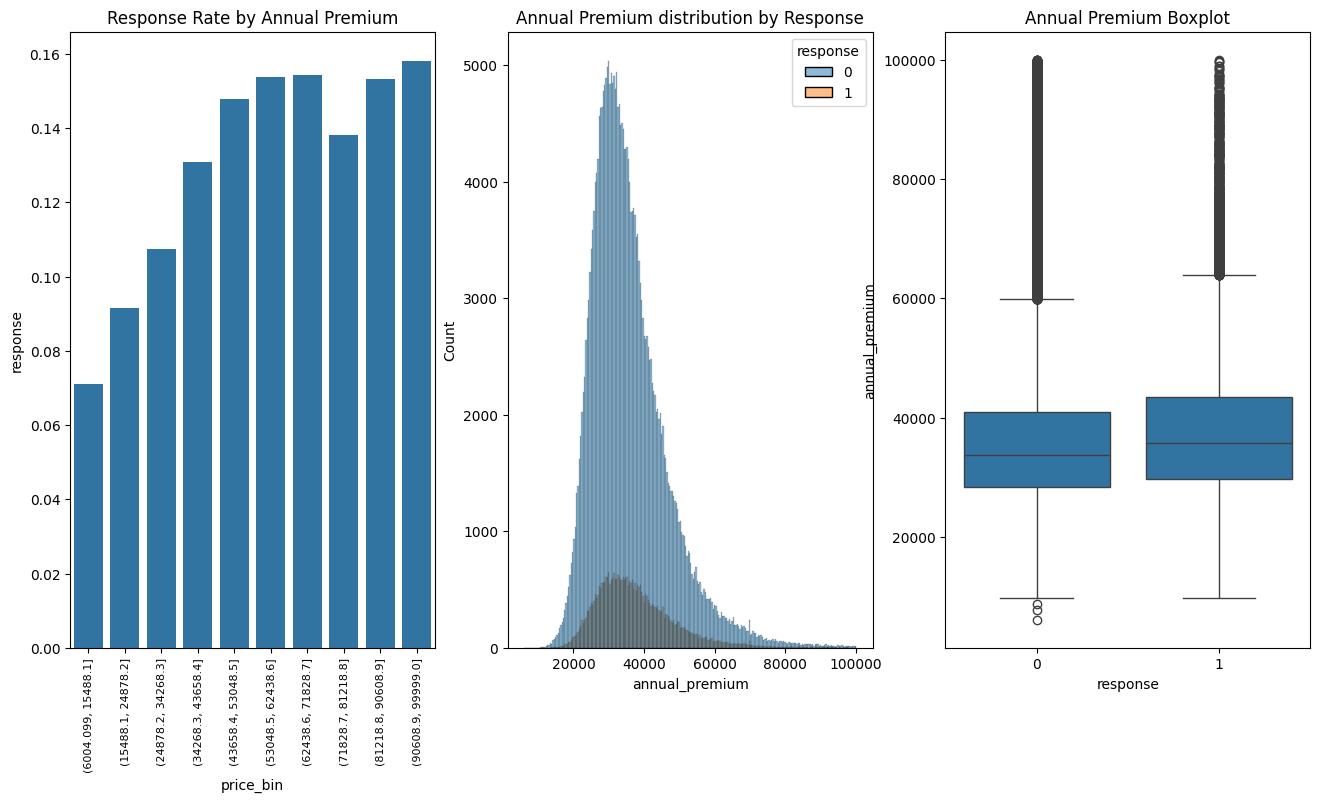

In [33]:
fig, axs = plt.subplots(figsize=(16, 8), nrows=1, ncols=3)
aux4 = df5[(df5['annual_premium'] >= 4000) & (df5['annual_premium'] < 100000)][['annual_premium', 'response']]
aux4['price_bin'] = pd.cut(aux4['annual_premium'], bins=10)
aux4 = aux4[['price_bin', 'response']].groupby('price_bin').mean().reset_index()

sns.barplot(data=aux4, x='price_bin', y='response', ax=axs[0])
axs[0].set_title('Response Rate by Annual Premium')
axs[0].set_xticklabels(rotation=90, labels=aux4['price_bin'], fontsize=8)

aux4 = df5[(df5['annual_premium'] >= 4000) & (df5['annual_premium'] < 100000)][['annual_premium', 'response']]

sns.histplot(x='annual_premium', data=aux4, hue='response', ax=axs[1])
axs[1].set_title('Annual Premium distribution by Response')

sns.boxplot(x='response', y='annual_premium', data=aux4, ax=axs[2])
axs[2].set_title('Annual Premium Boxplot')

plt.show()

### 5.2.5 Most customers pay for more expensive plans 

**False**: Most customers pays for intermediate plans

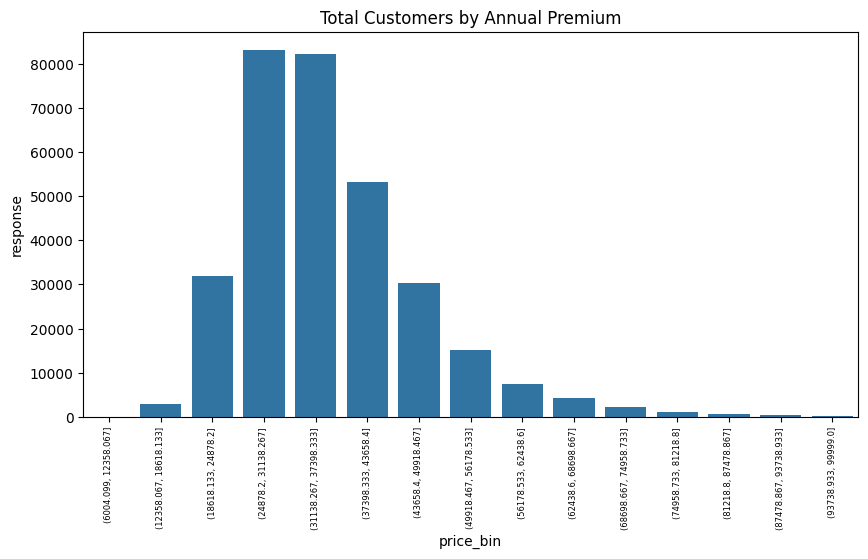

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))

aux5 = aux4.copy()
aux5['price_bin'] = pd.cut(aux5['annual_premium'], bins=15)
aux5 = aux5[['price_bin', 'response']].groupby('price_bin').count().reset_index()

sns.barplot(data=aux5, x='price_bin', y='response', ax=ax)
ax.set_title('Total Customers by Annual Premium')
ax.set_xticklabels(rotation=90, labels=aux5['price_bin'], fontsize=6)

plt.show()

### 5.2.6 Male customers tend to respond more positively  

**True**: Male customers are more interested in acquiring the car insurance

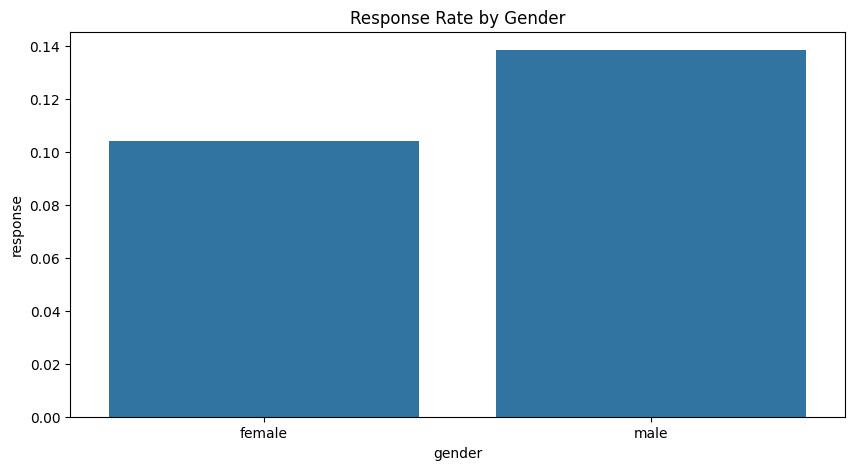

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
aux6 = df5[['gender', 'response']].groupby('gender').mean().reset_index()

sns.barplot(data=aux6, x='gender', y='response', ax=ax)
ax.set_title('Response Rate by Gender')

plt.show()

### 5.2.7 Male customers have more vehicle damages

**True**: Male customers have a higher damage rate

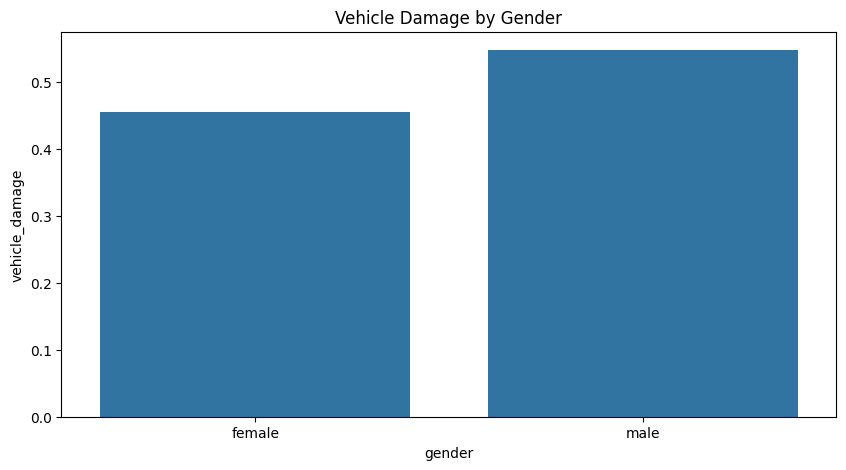

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
aux7 = df5[['gender', 'vehicle_damage']].groupby('gender').mean().reset_index()

sns.barplot(data=aux7, x='gender', y='vehicle_damage', ax=ax)
ax.set_title('Vehicle Damage by Gender')

plt.show()

### 5.2.8 The rate of customers who respond positively over the age of 60 is 2x that of those under 60

**False**: Elderly people is not so interested on acquiring a car insurance as adults.

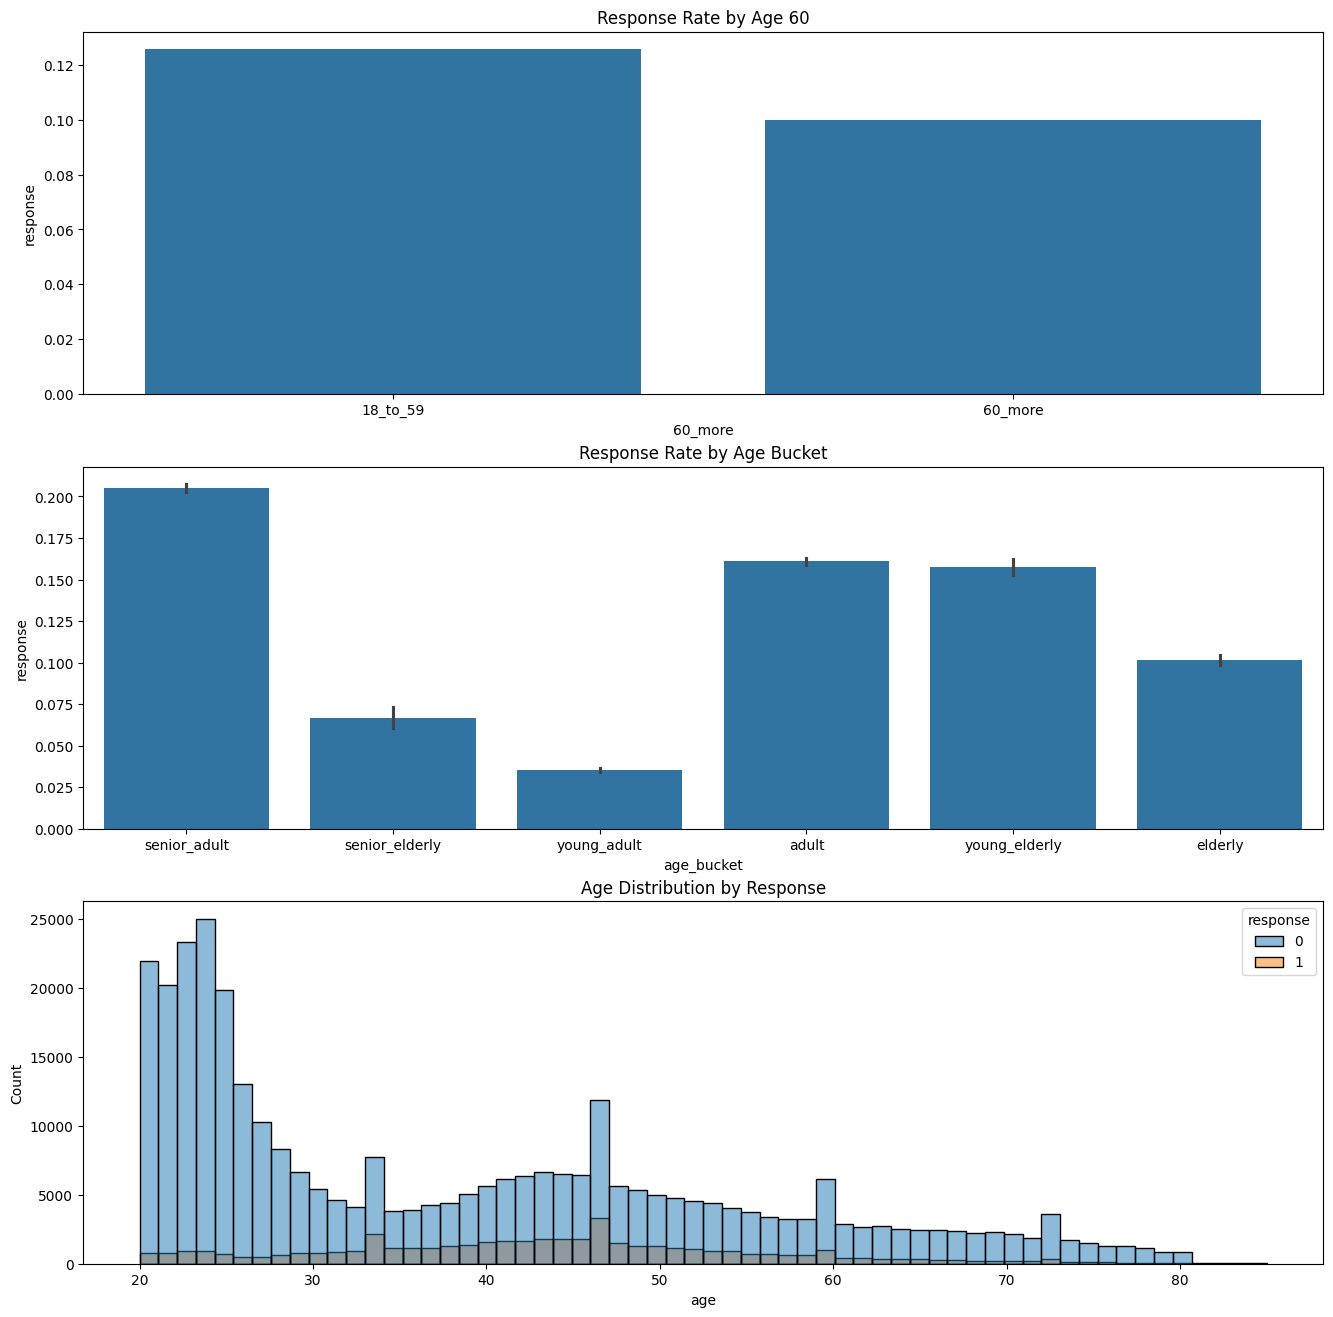

In [37]:
fig, axs = plt.subplots(figsize=(16, 16), nrows=3, ncols=1)
aux8 = df5[['age', 'response']]
aux8['60_more'] = aux8['age'].apply(lambda x: '60_more' if x >= 60 else '18_to_59')
aux8 = aux8[['60_more', 'response']].groupby('60_more').mean().reset_index()

sns.barplot(data=aux8, x='60_more', y='response', ax=axs[0])
axs[0].set_title('Response Rate by Age 60')

aux8 = df5[['age_bucket', 'response']]
sns.barplot(data=aux8, x='age_bucket', y='response', ax=axs[1])
axs[1].set_title('Response Rate by Age Bucket')

sns.histplot(x='age', data=df5, hue='response', ax=axs[2], bins=60)
axs[2].set_title('Age Distribution by Response')

plt.show()

### 5.2.9 There are richest regions than in comparasion to others

**False**: The average annual premium varies a lot from region to region. Except some few regions where the average annua premium is very low. Perpahps, we can derivate a feature to label these regions as **"lower purchase power".**

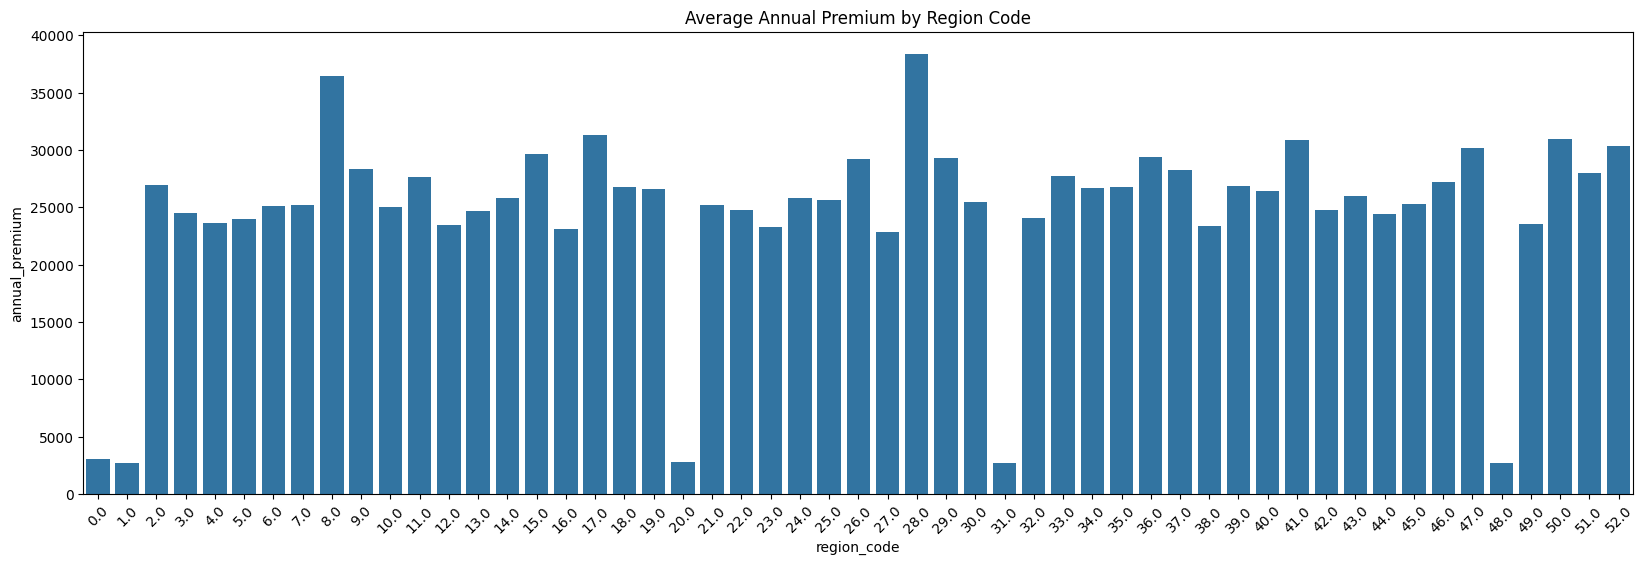

In [38]:
fig, ax = plt.subplots(figsize=(20, 6))

filter = df5['annual_premium'] < 150000
aux9 = df5.loc[filter, :][['annual_premium', 'region_code', 'response']].groupby('region_code').mean().reset_index()
sns.barplot(data=aux9, x='region_code', y='annual_premium', ax=ax)
ax.set_title('Average Annual Premium by Region Code')
ax.set_xticklabels(rotation=45, labels=aux9['region_code'])

plt.show()

## 5.3 Multivariate Analysis

### 5.3.1 Numerical Features

In [39]:
num_features = df5.select_dtypes(exclude=['object'])
num_features = num_features.drop(['region_code', 'policy_sales_channel'], axis=1)

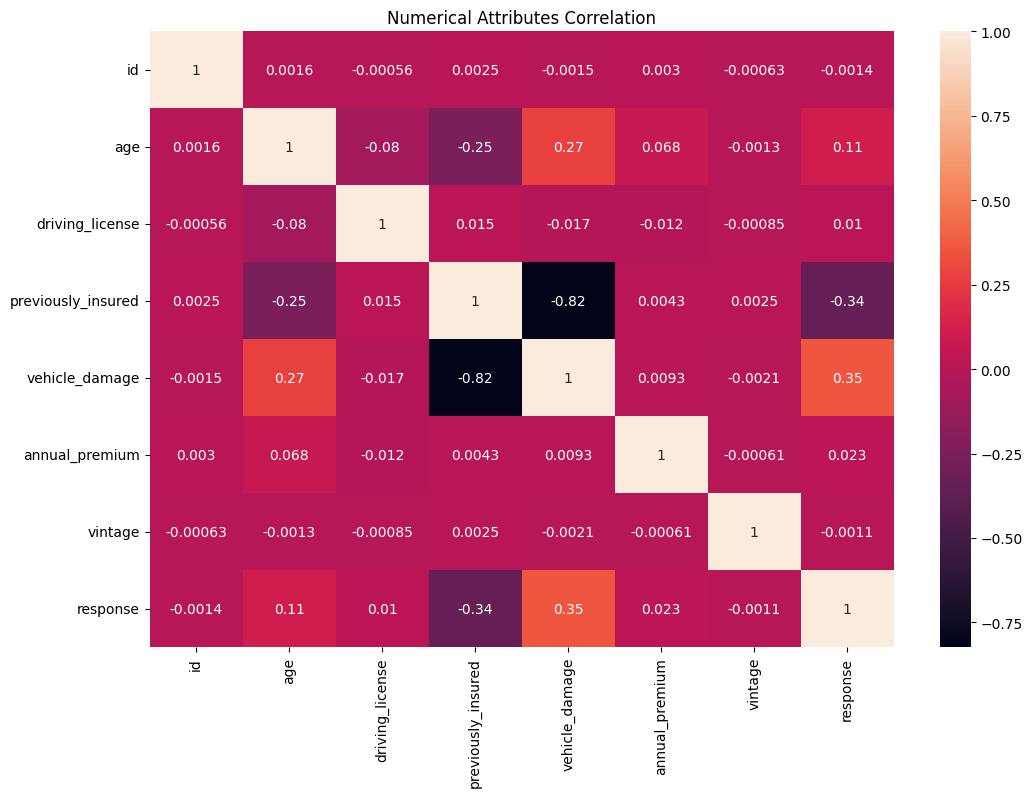

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

correlation = num_features.corr(method='pearson')
sns.heatmap(correlation, annot=True, ax=ax)
ax.set_title('Numerical Attributes Correlation')
plt.show()

### 5.3.2 Categorical Features

In [41]:
cat_features = df5.select_dtypes(include=['object'])

In [42]:
# create all possible combinations
# gender
c1 = cramers_v(cat_features, 'gender', 'gender') 
c2 = cramers_v(cat_features, 'gender', 'vehicle_age') 
c3 = cramers_v(cat_features, 'gender', 'age_bucket') 

# vehicle_age
c4 = cramers_v(cat_features, 'vehicle_age', 'gender')
c5 = cramers_v(cat_features, 'vehicle_age', 'vehicle_age')
c6 = cramers_v(cat_features, 'vehicle_age', 'age_bucket')

# age_bucket
c7 = cramers_v(cat_features, 'age_bucket', 'gender')
c8 = cramers_v(cat_features, 'age_bucket', 'vehicle_age')
c9 = cramers_v(cat_features, 'age_bucket', 'age_bucket')

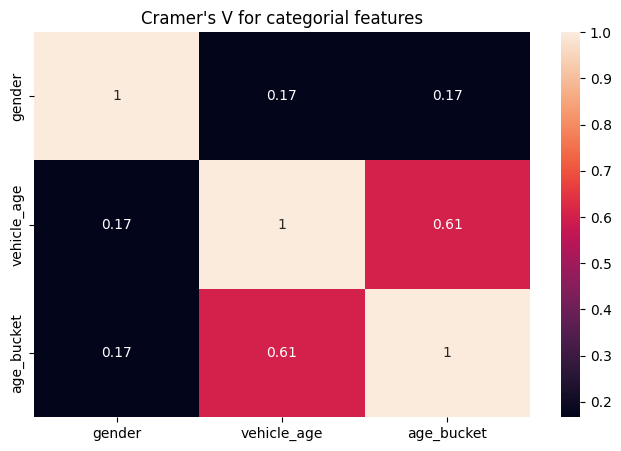

In [43]:
# create dataframe
aux = pd.DataFrame({
    'gender': [c1, c2, c3],
    'vehicle_age': [c4, c5, c6],
    'age_bucket': [c7, c8, c9]
})

# rename index to the same name of columns
aux = aux.set_index(aux.columns)

# create chart
fig, ax = plt.subplots(figsize=(8, 5))

sns.heatmap(aux, annot=True, ax=ax)
ax.set_title("Cramer's V for categorial features")
plt.show()

# 6. DATA MODELING AND PREPARATION

In [44]:
df6 = df5.copy()

In [45]:
# split predictor and response features
#X = df6.drop('response', axis=1)
#y = df6['response']

# split into train and validation
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# rebuild df6
#df6 = pd.concat([X_train, y_train], axis=1)

## 6.1 Standardization

In [46]:
#ss = StandardScaler()

# annual_premium
#df6['annual_premium'] = ss.fit_transform(df6[['annual_premium']].values)

## 6.2 Rescaling

In [47]:
mms = MinMaxScaler()
rs = RobustScaler()

# age
df6['age'] = mms.fit_transform(df6[['age']].values)

# annual_premium
df6['age'] = mms.fit_transform(df6[['annual_premium']].values)

# vintage
df6['vintage'] = mms.fit_transform(df6[['vintage']].values)

## 6.3 Transformation

In [48]:
# gender
df6 = pd.get_dummies(df6, columns=['gender'])

# region_code (target encoding)
target_encode_region = df6.groupby('region_code')['response'].mean().reset_index().rename(columns={'response':'region_response'})
df6 = df6.merge(target_encode_region, how='left', on='region_code')
df6['region_code'] = df6['region_response']

# vehicle_age
df6 = pd.get_dummies(df6, columns=['vehicle_age'])

# policy_sales_channel
target_encode_region = df6.groupby('policy_sales_channel')['response'].mean().reset_index().rename(columns={'response':'channel_response'})
df6 = df6.merge(target_encode_region, how='left', on='policy_sales_channel')
df6['policy_sales_channel'] = df6['channel_response']

# age bucket (ordinal encode)
df6['age_bucket'] = df6['age_bucket'].apply(lambda x: 1 if x == 'young_adult' else 2 if x == 'adult' else
                                                      3 if x == 'senior_adult' else 4 if x == 'young_elderly' else
                                                      5 if x == 'elderly' else 6)

In [49]:
# drop unwanted columns
df6.drop(['region_response', 'channel_response'], axis=1, inplace=True)

# 7. FEATURE SELECTION

In [50]:
df7 = df6.copy()

## 7.1 Boruta

In [51]:
# split predictor and response features
X = df7.drop('response', axis=1)
y = df7['response']

# split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# define random forest regressor
rf = RandomForestClassifier(n_jobs=1)

# adjust train and test data as arrays
#X_train_array = X_train.values
#y_train_array = y_train.values.ravel()

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_array, y_train_array)

In [53]:
#importances = dict(zip(X_train.columns, rf.feature_importances_))

#result = pd.DataFrame(importances, index=[0]).T.rename(columns={0:'importance'}).sort_values(by='importance', ascending=False)
#result

## 7.2 Extra Trees

In [54]:
# set model
etc = ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)
etc.fit(X_train.drop('id', axis=1), y_train)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

In [55]:
# get features importances
importances = etc.feature_importances_

# get importances std
std = np.std([t.feature_importances_ for t in etc.estimators_], axis=1)
indexes = np.argsort(importances)[::-1]

# show feature importance ranked
df = pd.DataFrame()

for i, j in zip(X_train.drop('id', axis=1), etc.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis=0)

df = df.sort_values('importance', ascending=False)
df

,feature,importance
0,vintage,0.258563
0,age,0.183557
0,annual_premium,0.183376
0,region_code,0.099886
0,policy_sales_channel,0.094966
0,vehicle_damage,0.066848
0,previously_insured,0.055108
0,age_bucket,0.032059
0,vehicle_age_less_than_1_year,0.013899
0,vehicle_age_between_1_2_years,0.006976


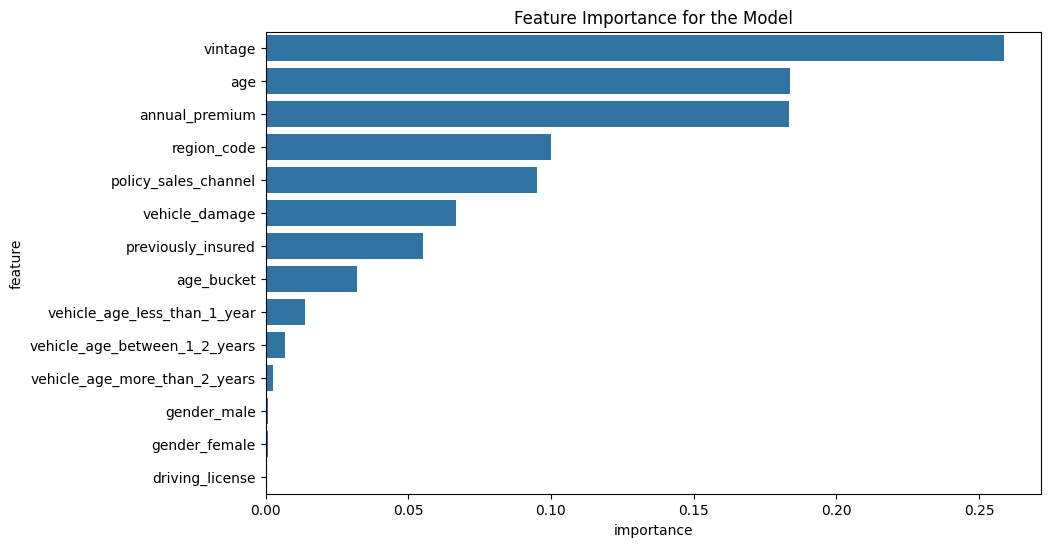

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(y='feature', x='importance', data=df, orient='h', ax=ax)
ax.set_title('Feature Importance for the Model')
plt.show()

In [57]:
# redefine columns
cols_selected = ['vintage', 'annual_premium', 'age', 'policy_sales_channel', 
                 'region_code']

# redefine train and validation
X_train = X_train[cols_selected]
X_val = X_val[cols_selected]

# 8. MACHINE LEARNING ALGORITHMS

# 8.1 KNN

In [58]:
# define model
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

# train knn
knn.fit(X_train, y_train)

# predict
yhat = knn.predict_proba(X_val)

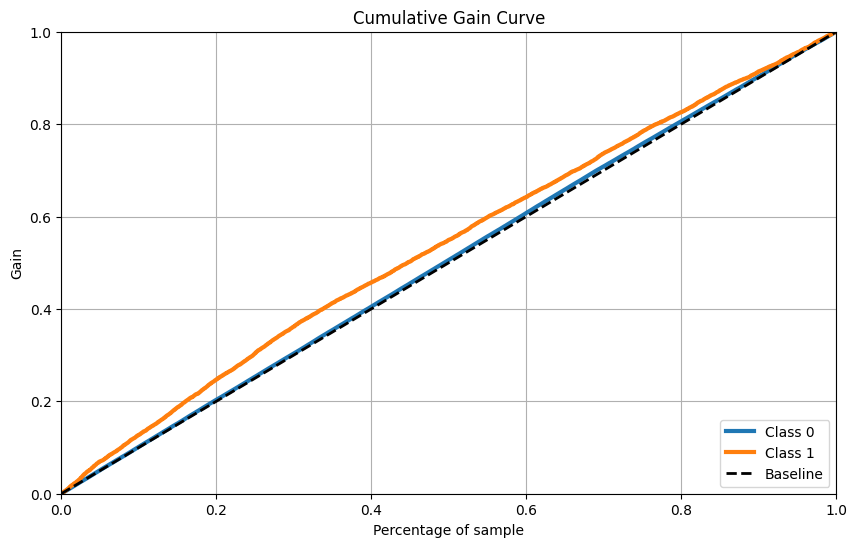

In [59]:
# gain curve
fig,ax = plt.subplots(figsize=(10, 6))

skplot.metrics.plot_cumulative_gain(y_val, yhat, ax=ax)
ax.set_title('Cumulative Gain Curve')
plt.show()

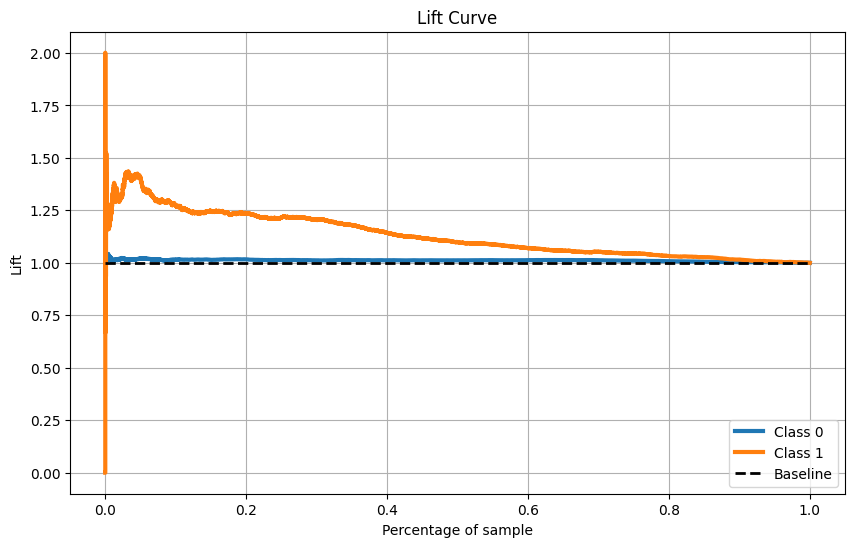

In [60]:
# lift curve
fig,ax = plt.subplots(figsize=(10, 6))

skplot.metrics.plot_lift_curve(y_val, yhat, ax=ax)
ax.set_title('Lift Curve')
plt.show()

In [80]:
# performance metrics
knn_precision = precision_at_k(y_val, yhat)
knn_recall = recall_at_k(y_val, yhat)

print(f'Precision: {knn_precision}')
print(f'Recall: {knn_recall}')

Precision: 0.1320
Recall: 0.0277


## 8.2 Logistic Regression

In [81]:
# define model
lr = LogisticRegression()

# train knn
lr.fit(X_train, y_train)

# predict
yhat = lr.predict_proba(X_val)

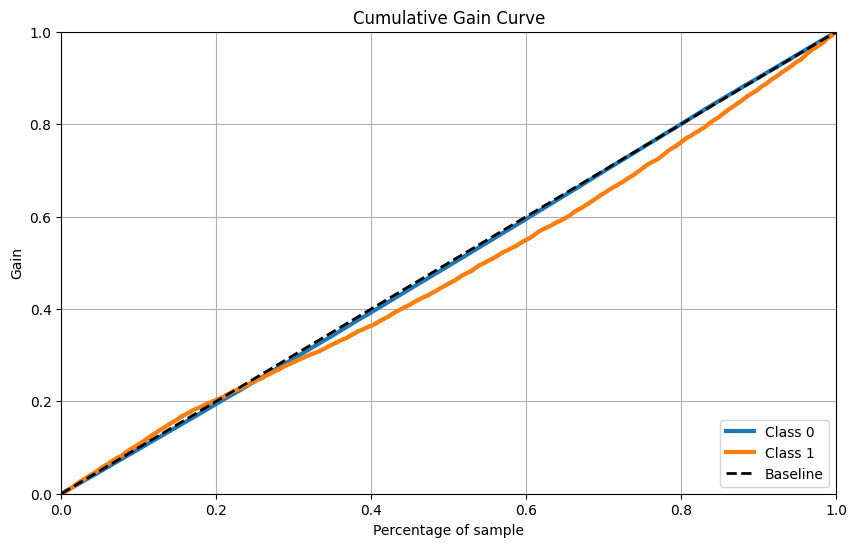

In [82]:
# gain curve
fig,ax = plt.subplots(figsize=(10, 6))

skplot.metrics.plot_cumulative_gain(y_val, yhat, ax=ax)
ax.set_title('Cumulative Gain Curve')
plt.show()

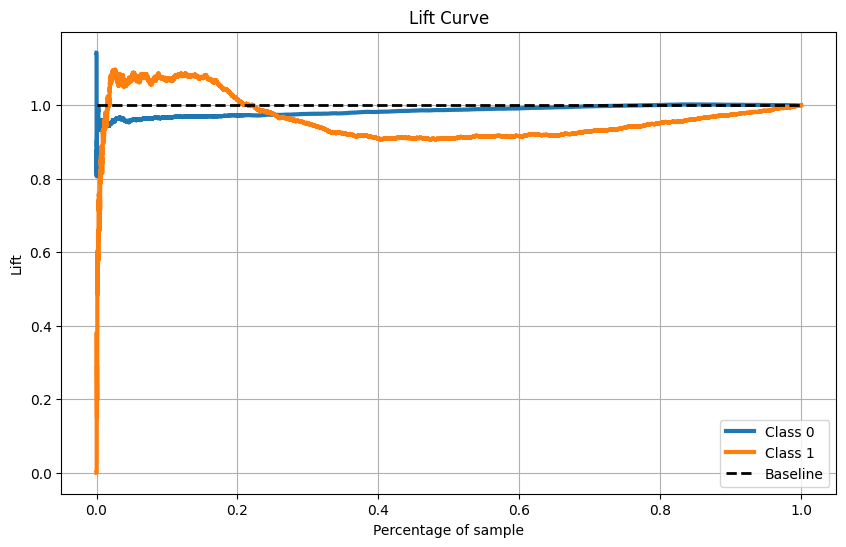

In [83]:
# lift curve
fig,ax = plt.subplots(figsize=(10, 6))

skplot.metrics.plot_lift_curve(y_val, yhat, ax=ax)
ax.set_title('Lift Curve')
plt.show()

In [84]:
# performance metrics
lr_precision = precision_at_k(y_val, yhat)
lr_recall = recall_at_k(y_val, yhat)

print(f'Precision: {lr_precision}')
print(f'Recall: {lr_recall}')

Precision: 0.1260
Recall: 0.0265


## 8.3 SVM Classifier

In [ ]:
# define model
#svc = SVC(probability=True)

# train knn
#svc.fit(X_train, y_train)

# predict
#yhat = svc.predict_proba(X_val)

In [ ]:
# gain curve
#fig,ax = plt.subplots(figsize=(10, 6))

#skplot.metrics.plot_cumulative_gain(y_val, yhat, ax=ax)
#ax.set_title('Cumulative Gain Curve')
#plt.show()

In [ ]:
# lift curve
#fig,ax = plt.subplots(figsize=(10, 6))

#skplot.metrics.plot_lift_curve(y_val, yhat, ax=ax)
#ax.set_title('Lift Curve')
#plt.show()

In [ ]:
# precision_at_k
#svm_precision = precision_at_k(y_val, yhat)
#svm_precision

## 8.4 Random Forest

In [85]:
# define model
rfc = RandomForestClassifier(n_estimators=250)

# train knn
rfc.fit(X_train, y_train)

# predict
yhat = rfc.predict_proba(X_val)

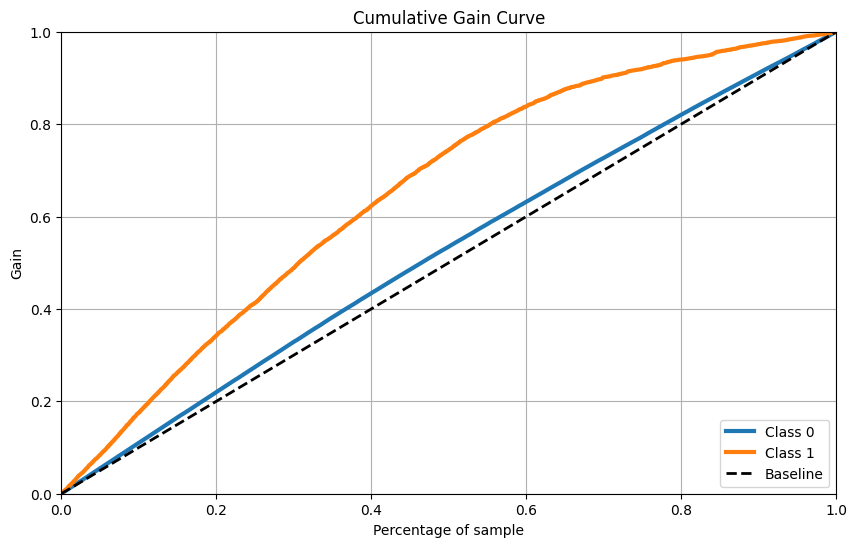

In [86]:
# gain curve
fig,ax = plt.subplots(figsize=(10, 6))

skplot.metrics.plot_cumulative_gain(y_val, yhat, ax=ax)
ax.set_title('Cumulative Gain Curve')
plt.show()

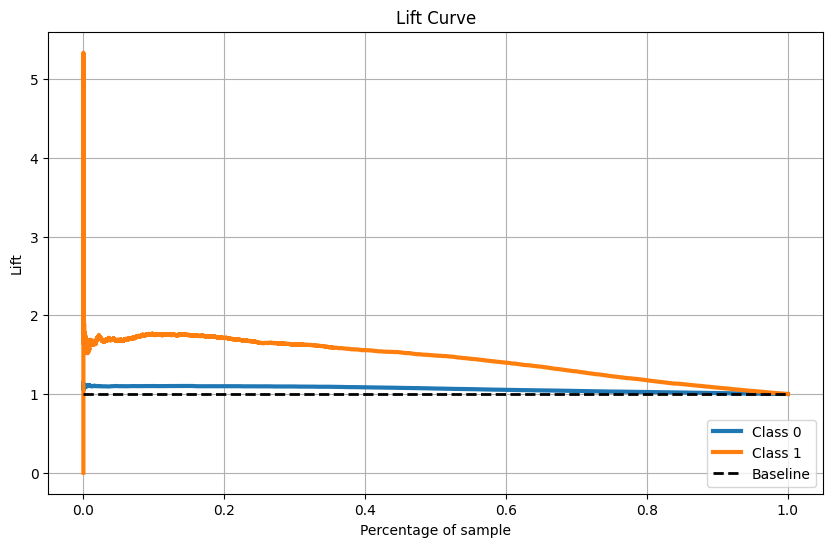

In [87]:
# lift curve
fig,ax = plt.subplots(figsize=(10, 6))

skplot.metrics.plot_lift_curve(y_val, yhat, ax=ax)
ax.set_title('Lift Curve')
plt.show()

In [88]:
# performance metrics
rf_precision = precision_at_k(y_val, yhat)
rf_recall = recall_at_k(y_val, yhat)

print(f'Precision: {rf_precision}')
print(f'Recall: {rf_recall}')

Precision: 0.1250
Recall: 0.0263


## 8.5 XgBoost

In [89]:
# define model
xgb = xgb.XGBClassifier(random_state=42, learning_rate=0.1)

# train knn
xgb.fit(X_train, y_train)

# predict
yhat = xgb.predict_proba(X_val)

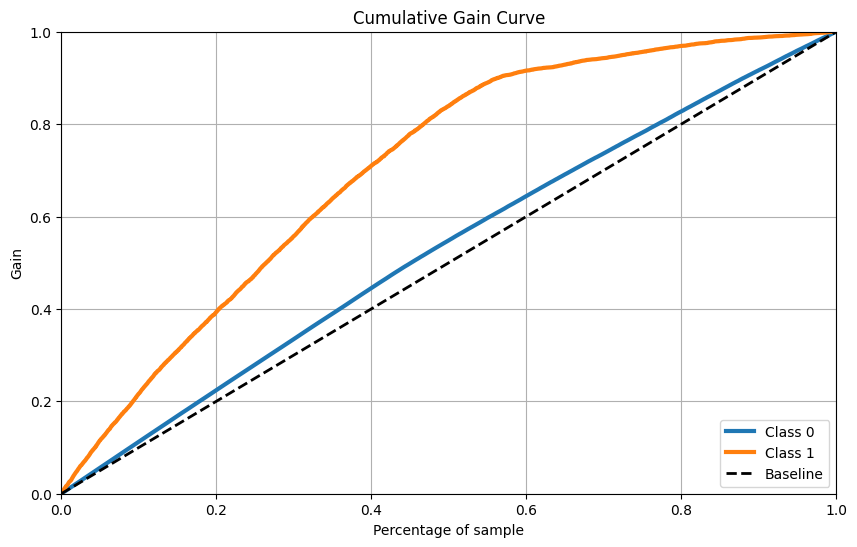

In [90]:
# gain curve
fig,ax = plt.subplots(figsize=(10, 6))

skplot.metrics.plot_cumulative_gain(y_val, yhat, ax=ax)
ax.set_title('Cumulative Gain Curve')
plt.show()

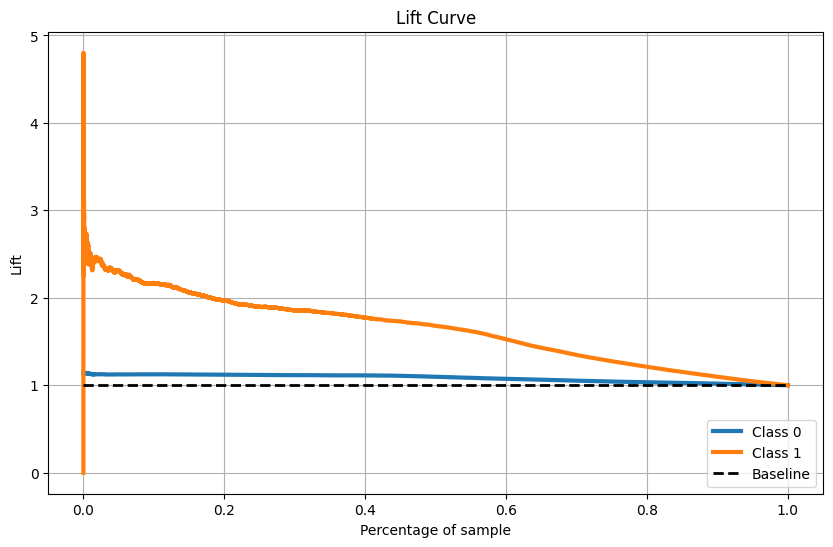

In [91]:
# lift curve
fig,ax = plt.subplots(figsize=(10, 6))

skplot.metrics.plot_lift_curve(y_val, yhat, ax=ax)
ax.set_title('Lift Curve')
plt.show()

In [92]:
# performance metrics
xgb_precision = precision_at_k(y_val, yhat)
xgb_recall = recall_at_k(y_val, yhat)

print(f'Precision: {xgb_precision}')
print(f'Recall: {xgb_recall}')

Precision: 0.1260
Recall: 0.0265


In [95]:
## 8.6 Overall Performance

result = pd.DataFrame({
    'knn' : [knn_precision, knn_recall],
    'logistic_regression': [lr_precision, lr_recall],
    'random_forest': [rf_precision, rf_recall],
    'xg_boost': [xgb_precision, xgb_recall]}).T.rename({0: 'precision_top_k', 1: 'recall_top_k'}, axis=1)

result.sort_values(by='precision_top_k', ascending=False)

,precision_top_k,recall_top_k
knn,0.1320,0.0277
logistic_regression,0.1260,0.0265
xg_boost,0.1260,0.0265
random_forest,0.1250,0.0263


# 9. MACHINE LEARNING MODEL

# 10. ALGORITHM PERFORMANCE AND ASSESSMENT